In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch

from torch.utils.data import DataLoader, TensorDataset
import numpy as np

import matplotlib.pyplot as plt


In [3]:
from nflows.flows import MaskedAutoregressiveFlow

from counterfactuals.datasets.heloc import HelocDataset
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.datasets.law import LawDataset
from counterfactuals.datasets.compas import CompasDataset

from counterfactuals.optimizers.approach_three import ApproachThree

from counterfactuals.metrics.metrics import (
    perc_valid_cf,
    perc_valid_actionable_cf,
    continuous_distance,
    categorical_distance,
    distance_l2_jaccard,
    distance_mad_hamming,
    plausibility
)

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = CompasDataset(file_path="../data/compas_two_years.csv")
train_dataloader = dataset.train_dataloader(batch_size=128, shuffle=True)
test_dataloader = dataset.test_dataloader(batch_size=128, shuffle=False)

In [5]:
# disc_model = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=100)
disc_model = LogisticRegression()
disc_model.fit(dataset.X_train, dataset.y_train.reshape(-1))
print(classification_report(dataset.y_test, disc_model.predict(dataset.X_test)))

y_pred_train = disc_model.predict(dataset.X_train)
y_pred_test = disc_model.predict(dataset.X_test)

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       423
         1.0       0.80      0.81      0.80       419

    accuracy                           0.80       842
   macro avg       0.80      0.80      0.80       842
weighted avg       0.80      0.80      0.80       842



In [6]:
pred_train_dataloader = DataLoader(
    dataset=TensorDataset(
        torch.from_numpy(dataset.X_train),
        torch.from_numpy(disc_model.predict(dataset.X_train))
    ),
    shuffle=True,
    batch_size=128
)

pred_test_dataloader = DataLoader(
    dataset=TensorDataset(
        torch.from_numpy(dataset.X_test),
        torch.from_numpy(disc_model.predict(dataset.X_test))
    ),
    shuffle=False,
    batch_size=128
)

In [11]:
flow = MaskedAutoregressiveFlow(features=dataset.X_train.shape[1], hidden_features=16, context_features=1)

In [12]:
flow = MaskedAutoregressiveFlow(features=dataset.X_train.shape[1], hidden_features=16, context_features=1)
cf = ApproachThree(model=flow)

In [33]:
cf.train_model(
    train_loader=train_dataloader,
    test_loader=test_dataloader,
    epochs=50,
)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Epochs: 0, Loss: nan:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 49, Train: -29.8487, test: -30.0918: 100%|██████████| 50/50 [00:03<00:00, 15.20it/s]


In [34]:
cf.test_model(test_loader=test_dataloader)

{'0.0': {'precision': 0.7989130434782609,
  'recall': 0.6950354609929078,
  'f1-score': 0.7433628318584071,
  'support': 423.0},
 '1.0': {'precision': 0.7278481012658228,
  'recall': 0.8233890214797136,
  'f1-score': 0.7726763717805152,
  'support': 419.0},
 'accuracy': 0.7589073634204275,
 'macro avg': {'precision': 0.7633805723720418,
  'recall': 0.7592122412363107,
  'f1-score': 0.7580196018194612,
  'support': 842.0},
 'weighted avg': {'precision': 0.7635493727098386,
  'recall': 0.7589073634204275,
  'f1-score': 0.757949973458601,
  'support': 842.0}}

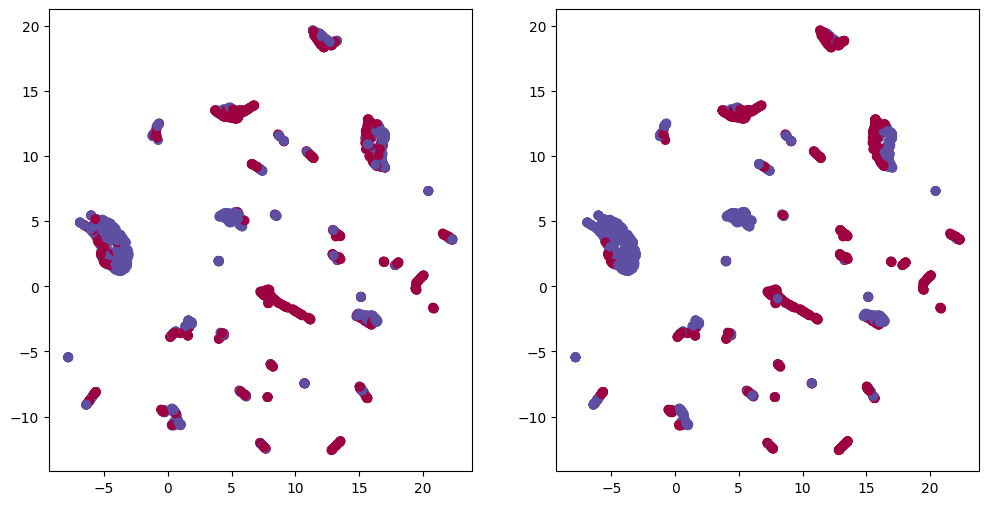

In [35]:
import umap

umap = umap.UMAP()
X_train_umap = umap.fit_transform(dataset.X_train)
X_test_umap = umap.transform(dataset.X_test)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=dataset.y_train, cmap="Spectral")
plt.subplot(1, 2, 2)
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_pred_train, cmap="Spectral")

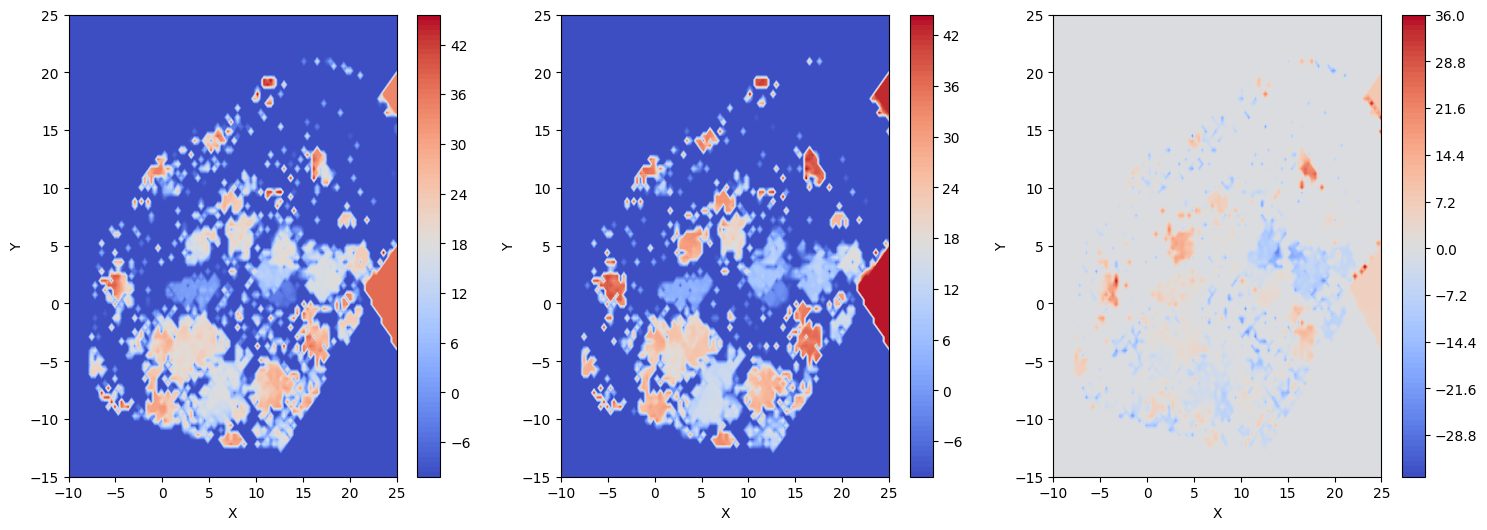

In [63]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 25, 100)
y = np.linspace(-15, 25, 100)
X, Y = np.meshgrid(x, y)
# Calculate the predictions for each point in the grid
data = umap.inverse_transform(np.c_[X.ravel(), Y.ravel()])

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
with torch.no_grad():
    Z_0 = cf.model.log_prob(torch.tensor(data).float(), context=torch.zeros(data.shape[0], 1)).reshape(X.shape)
Z_0[Z_0 < -10] = -10
plt.contourf(X, Y, Z_0, levels=100, cmap='coolwarm')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 2)
with torch.no_grad():
    Z_1 = cf.model.log_prob(torch.tensor(data).float(), context=torch.ones(data.shape[0], 1)).reshape(X.shape)
Z_1[Z_1 < -10] = -10
plt.contourf(X, Y, Z_1, levels=100, cmap='coolwarm')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

plt.subplot(1, 3, 3)
Z = Z_1 - Z_0
# Z[Z < -10] = -10
plt.contourf(X, Y, Z, levels=100, cmap='coolwarm')
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')

plt.show()

In [65]:
Xs_cfs, Xs, ys_orig = cf.search_batch(
    dataloader=pred_test_dataloader,
    epochs=300,
    lr=0.005,
    alpha=20,
    beta=0.01,
)
print(Xs_cfs)

100%|██████████| 7/7 [00:12<00:00,  1.78s/it]

[[ 6.55737668e-02  0.00000000e+00  9.73709859e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 4.50082809e-01  9.62414220e-02 -3.49599565e-03 ... -2.81897373e-04
  -2.07465724e-03  1.06189551e-03]
 [ 2.41679728e-01  4.91807051e-02 -5.92653127e-03 ...  2.43504735e-04
   9.98424948e-04 -3.55037046e-04]
 ...
 [ 3.14109594e-01  2.98222005e-02  5.15324483e-03 ...  3.23098945e-03
  -3.37330229e-03 -1.48982013e-04]
 [ 1.04837105e-01  1.45681826e-02 -1.19470782e-03 ...  5.46398980e-04
   1.64290634e-03 -2.86959368e-03]
 [ 2.79222459e-01  1.83411911e-01 -5.63468132e-03 ...  7.85537239e-04
   2.55555788e-04 -3.17233673e-04]]


In [10]:
Xs_cfs = cf.generate_counterfactuals(Xs=dataset.X_test[:100], ys=dataset.y_test[:100], num_epochs=200, lr=0.005, alpha=20, beta=0.01)
Xs_cfs = torch.concat(Xs_cfs).detach()

0it [00:00, ?it/s]

100it [01:32,  1.08it/s]


In [11]:
X = dataset.X_test[:100]
ys_cfs_pred = cf.predict_model(Xs_cfs)
ys_orig_pred = cf.predict_model(dataset.X_test[:100])
ys_orig = dataset.y_test[:100].flatten()

{
    "valid_cf": perc_valid_cf(ys_orig_pred, y_cf=ys_cfs_pred),
    "valid_cf_for_orig_data": perc_valid_cf(ys_orig, y_cf=ys_cfs_pred),
    # "perc_valid_actionable_cf": perc_valid_actionable_cf(X=dataset.X_test[:100], X_cf=Xs_cfs, y=ys_orig_pred, y_cf=ys_cfs_pred, actionable_features=[1,2]),
    "continuous_distance": continuous_distance(X=X, X_cf=Xs_cfs, continuous_features=dataset.continuous_columns, metric='mad', X_all=dataset.X_test),
    "categorical_distance": categorical_distance(X=X, X_cf=Xs_cfs, categorical_features=dataset.categorical_columns, metric='jaccard', agg='mean'),
    "distance_l2_jaccard": distance_l2_jaccard(X=X, X_cf=Xs_cfs, continuous_features=dataset.continuous_columns, categorical_features=dataset.categorical_columns),
    "distance_mad_hamming": distance_mad_hamming(X=X, X_cf=Xs_cfs,
                                                 continuous_features=dataset.continuous_columns, categorical_features=dataset.categorical_columns, X_all=X, agg='mean'),
    "plausibility": plausibility(
        X, Xs_cfs, ys_orig,
        continuous_features_all=dataset.continuous_columns,
        categorical_features_all=dataset.categorical_columns,
        X_train=dataset.X_train,
        ratio_cont=None
    ),
    "log_density": np.mean(cf.predict_model(test_dataloader))
}

{'valid_cf': 0.77,
 'valid_cf_for_orig_data': 1.0,
 'continuous_distance': 44.1639847685898,
 'categorical_distance': 0.77,
 'distance_l2_jaccard': 0.5472639875705996,
 'distance_mad_hamming': 20.96497410749426,
 'plausibility': 20.804536163113323,
 'log_density': 0.48812351543942994}